## Studio Analysis

### Importing Libarbries 

In [136]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

### Reading Data

In [137]:
bom = pd.read_csv("bom.movie_gross.csv.gz")
rt_movie = pd.read_csv("rt.movie_info.tsv.gz", sep='\t')
rt_reviews = pd.read_csv("rt.reviews.tsv.gz", sep='\t', encoding='windows-1252')
tmdb = pd.read_csv("tmdb.movies.csv.gz")
tn_budgets = pd.read_csv("tn.movie_budgets.csv.gz")
conn = sqlite3.connect('im.db')
cur = conn.cursor()
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
table_names = cur.fetchall()

## Data Cleaning

### Removing uncessary strings & filling and removing NA columns

In [138]:
###drop currency and box office and studio columns??
bom['foreign_gross']= bom['foreign_gross'].str.replace(',','')
bom['foreign_gross'] = bom['foreign_gross'].fillna(0)
bom = bom.astype({'foreign_gross': float})
bom['domestic_gross'] = bom['domestic_gross'].fillna(0)
bom = bom[bom['studio'].notna()]
rt_reviews = rt_reviews[rt_reviews['rating'].notna()]
rt_reviews = rt_reviews[rt_reviews['review'].notna()]
rt_reviews = rt_reviews[rt_reviews['critic'].notna()]
rt_reviews = rt_reviews[rt_reviews['publisher'].notna()]

In [139]:
tn_budgets['release_date'] = pd.to_datetime(tn_budgets['release_date'])
tn_budgets['production_budget'] = tn_budgets['production_budget'].str.replace('$','')
tn_budgets['production_budget'] = tn_budgets['production_budget'].str.replace(',','')
tn_budgets = tn_budgets.astype({'production_budget': 'int64'})
tn_budgets['domestic_gross'] = tn_budgets['domestic_gross'].str.replace('$','')
tn_budgets['domestic_gross'] = tn_budgets['domestic_gross'].str.replace(',','')
tn_budgets = tn_budgets.astype({'domestic_gross': 'int64'})
tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].str.replace('$','')
tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].str.replace(',','')
tn_budgets = tn_budgets.astype({'worldwide_gross': 'int64'})

In [ ]:
### Cleaning Studio columns to remove duplicates 

In [140]:
bom['studio'].unique()
bom['studio'] = bom['studio'].str.strip('()')
bom['studio'] = bom['studio'].str.strip('(NL')
bom['studio'] = bom['studio'].str.strip()
bom['studio'] = bom['studio'].str.strip()

In [141]:
bom['studio'] = bom['studio'].str.strip()

In [143]:
tn_budgets['year'] =  pd.DatetimeIndex(tn_budgets['release_date']).year

In [144]:
bom_budgets = pd.merge(tn_budgets, bom[['studio','title', 'year']],left_on=['movie','year'], right_on = ['title','year'], how = 'inner')

In [145]:
bom_budgets['net'] = bom_budgets['worldwide_gross'] - bom_budgets['domestic_gross']

### groups by studio and takes the top ten Studio by net profit

In [146]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
net_studio = bom_budgets.groupby("studio")['net'].mean().to_frame(name = 'average_net').reset_index()
top10_studio = net_studio.sort_values(by=['average_net'], ascending= False, na_position='first').head(10)
#Reduces the amount of digits displayed
top10_studio['average_net'] = top10_studio['average_net'] / 100

In [147]:
top10_studio

,studio,average_net
61,P/DW,3395112.915
14,BV,2827760.523
41,GrtIndia,2445171.200
32,Fox,1578636.946
79,Sony,1444089.179
86,Uni.,1440045.254
90,WB,1317622.431
66,Par.,1168924.193
85,UTV,979403.107
35,G/S,772039.933


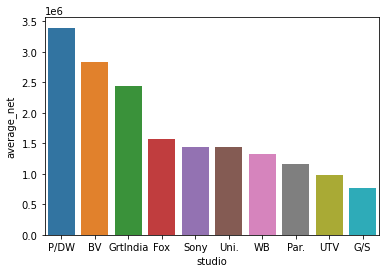

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=top10_studio, x='studio', y='average_net')
plt.show()

In [149]:
bom_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,studio,title,net
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,BV,Pirates of the Caribbean: On Stranger Tides,804600000
1,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,BV,Avengers: Age of Ultron,944008095
2,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,2018,BV,Avengers: Infinity War,1369318718
3,9,2017-11-17,Justice League,300000000,229024295,655945209,2017,WB,Justice League,426920914
4,10,2015-11-06,Spectre,300000000,200074175,879620923,2015,Sony,Spectre,679546748
...,...,...,...,...,...,...,...,...,...,...
1209,68,2012-04-27,Sound of My Voice,135000,408015,429448,2012,FoxS,Sound of My Voice,21433
1210,73,2012-06-15,Your Sister's Sister,120000,1597486,3090593,2012,IFC,Your Sister's Sister,1493107
1211,80,2015-07-10,The Gallows,100000,22764410,41656474,2015,WB,The Gallows,18892064
1212,86,2017-07-07,A Ghost Story,100000,1594798,2769782,2017,A24,A Ghost Story,1174984


In [161]:
studio_cost = bom_budgets.groupby("studio")['production_budget'].mean().to_frame(name = 'average_cost').reset_index()

In [163]:
studio_cost['average_cost'].quantile([0.25, 0.5, 0.75])

0.250    6407142.857
0.500   12416666.667
0.750   24796428.571
Name: average_cost, dtype: float64

In [164]:
low_budget_studios = studio_cost[studio_cost['average_cost'] <= 6407142.857]

In [172]:
list_low = list(low_budget_studios['studio'])
for i in list_low:
    low_cost_studios = bom_budgets[bom_budgets['studio'] ==  i].append(low_cost_studios)

In [174]:
low_cost_studios

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,studio,title,net
1124,25,2010-04-09,Letters to God,3000000,2848587,3237452,2010,Viv.,Letters to God,388865
1188,58,2014-05-09,Palo Alto,1000000,767732,1156309,2014,Trib.,Palo Alto,388577
1029,87,2015-01-23,Song One,6000000,32251,437089,2015,TFA,Song One,404838
1095,22,2011-09-23,Red State,4000000,1065429,1983596,2011,SMod,Red State,918167
1028,71,2018-09-14,Mandy,6000000,1214525,1427656,2018,RLJ,Mandy,213131
1123,21,2016-04-22,Compadres,3000000,3127773,7445044,2016,PNT,Compadres,4317271
1102,52,2011-11-18,Another Happy Day,4000000,9120,978527,2011,P4,Another Happy Day,969407
1093,18,2012-08-24,Samsara,4000000,2672413,5966671,2012,Osci.,Samsara,3294258
1154,40,2011-04-08,Meek's Cutoff,2000000,977772,1869928,2011,Osci.,Meek's Cutoff,892156
1139,25,2016-06-24,Hunt for the Wilderpeople,2500000,5205471,23845533,2016,Orch.,Hunt for the Wilderpeople,18640062


In [169]:
low_cost_studios

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,studio,title,net
1124,25,2010-04-09,Letters to God,3000000,2848587,3237452,2010,Viv.,Letters to God,388865


In [ ]:
bom_budgets[bom_budgets['production_budget'] >= 60000000 ]

In [152]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})
low_budget = np.array(low_budget_studios.groupby('studio')['net'].mean())

In [153]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
low_net_studio = low_budget_studios.groupby("studio")['net'].mean().to_frame(name = 'average_net').reset_index()
top10_low = low_net_studio.sort_values(by=['average_net'], ascending= False, na_position='first').head(10)

In [154]:
top10_low['studio']

65          UTV
49         Par.
66         Uni.
70           WB
23           FD
21         Eros
29          G/S
44        Orch.
25        Focus
13    Cleopatra
Name: studio, dtype: object

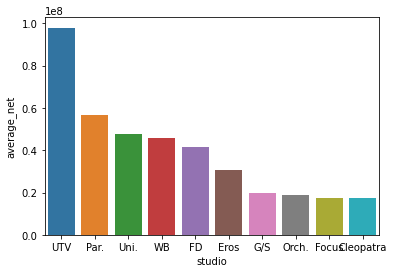

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=top10_low, x='studio', y='average_net')
plt.show()

In [135]:
fig, ax = p
lt.subplots(figsize =(10, 7))
ax.hist(net_studio)

NameError: name 'p' is not defined